# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [12]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point" # "3-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 20 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.2

# Mock cycle/two-level cycle nu value list.
nu_values = np.arange(1, 12)

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513018


In [13]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)

# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

## Auto-setup

In [14]:
# multilevel = hm.setup.auto_setup.setup(level.a, level.location, domain_size, max_levels=2, 
#                                        repetitive=True, symmetrize=True,
#                                       num_bootstrap_steps=1, caliber=4)

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.292e+00                    4.472e-01    2.887
INFO     1     7.181e-01 (0.556) [0.556]    3.452e-01    2.083 (0.721)
INFO     2     4.232e-01 (0.589) [0.572]    2.974e-01    1.427 (0.685)
INFO     3     2.672e-01 (0.632) [0.592]    2.726e-01    0.985 (0.690)
INFO     4     1.824e-01 (0.683) [0.613]    2.579e-01    0.712 (0.723)
INFO     5     1.366e-01 (0.748) [0.638]    2.481e-01    0.555 (0.778)
INFO     6     1.106e-01 (0.809) [0.664]    2.409e-01    0.463 (0.834)
INFO     7     9.391e-02 (0.850) [0.688]    2.352e-01    0.403 (0.871)
INFO     8     8.276e-02 (0.882) [0.710]    2.304e-01    0.362 (0.901)
INFO     9     7.473e-02 (0.904) [0.729]    2.263e-01    0.333 (0.920)
INFO     10    6.864e-02 (0.919) [0.746]    2.227e-01    0.310 (0.934)
INFO     11    6.385e-02 (0.930) [0.761]    2.194e-01    0.293 (0.944)
INFO     12    5.996e-02 (0.939) [0.775]    2.165e-01    0.278 (0.952)
INFO 

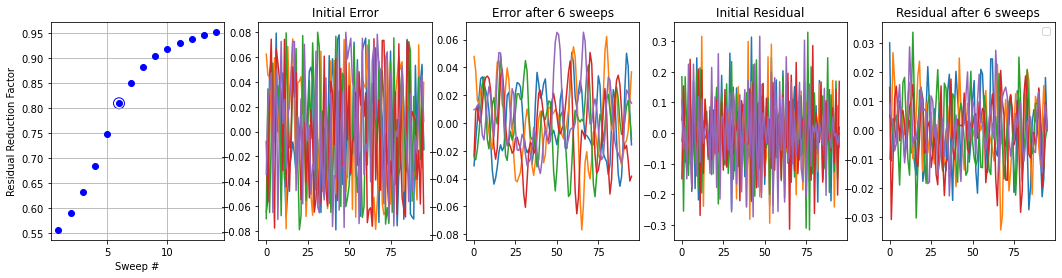

In [18]:
ml = hm.setup.hierarchy.multilevel.Multilevel.create(level)
aggregate_size = 4
num_components = 2
m = 4
num_bootstrap_steps = 2 if not ideal_tv else 1

for l in range(3):
    # Check relaxation shrinkage & convergence.
    method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
        multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
    num_sweeps = method_info["Kaczmarz"][1]
    nu = 2 * num_sweeps

    for i in range(num_bootstrap_steps):
        # Create/improve TFs.
        if i == 0:
            x = initial_tv(level, nu: int, ideal_tv=ideal_tv), num_examples=num_examples)
        else:
            x = helmholtz.analysis.stats.improve_tv(x, multilevel, num_cycles=1, print_frequency=None)

        # Update coarsening using current TFs.
        ml1 = helmholtz.analysis.stats.build_coarse_level(ml[-1], x,
                               domain_size,
                               aggregate_size, num_components,
                               ideal_tv=ideal_tv,
                               interpolation_method=interpolation_method,
                               fit_scheme=fit_scheme,
                               weighted=weighted,
                               neighborhood=neighborhood,
                               repetitive=repetitive,
                               m=m,
                               use_q=False)
    ml.add(ml1[1])

In [ ]:
# Using GMRES as as a coarse-level solver seems to be a robust choice vs. m (domain size).
m = None
nu_coarsest = -1
hm.repetitive.locality.two_level_conv_factor(
    ml, 8, num_levels=3,
    nu_coarsest=200, print_frequency=1, debug=False, num_sweeps=10);